In [1]:
import torch
import torch.nn as nn
import torchvision
from model_file import *
from vce_dataloader import getBinaryDataLoader, getAllDataLoader, visualize_batch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
model = getModel("vgg16_bn")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 89.1MB/s]


In [3]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

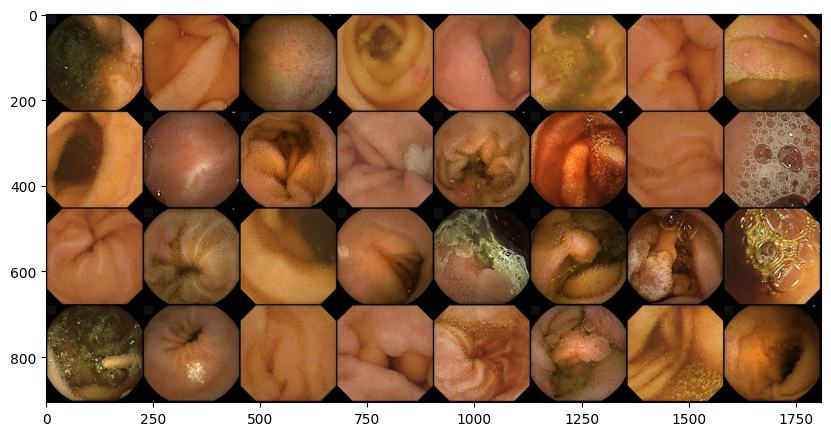

In [4]:
binaryDL_train = getBinaryDataLoader(image_size=(224,224), target_class_name="Normal", path_to_dataset="/kaggle/input/vce-dataset/training",batch_size=32, sampling = True)
binaryDL_val = getBinaryDataLoader(image_size=(224,224), target_class_name="Normal", path_to_dataset="/kaggle/input/vce-dataset/validation",batch_size=32, sampling = True)
visualize_batch(binaryDL_train, nrow = 8)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
sum = 0
for images, labels in binaryDL_train:
    print(images.shape)  # Should print [batch_size, 1, 48, 48]
    print(labels.shape)  # Should print [batch_size]
    sum = sum + torch.sum(labels)
    break
print(sum)

torch.Size([32, 3, 224, 224])
torch.Size([32])
tensor(17)


In [7]:
# print(labels)

In [8]:
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 2)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

In [9]:
model = model.to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [11]:
num_epochs = 10

In [12]:
for epoch in range(num_epochs):
    model.train()
    
    running_loss = 0.0
    correct_predictions = 0
    total_samples  =0
    
    for inputs, labels in binaryDL_train:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        
    train_loss = running_loss / total_samples
    train_accuracy = correct_predictions / total_samples
    
    model.eval()
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in binaryDL_val:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            
            val_loss += loss.item() * val_inputs.size(0)
            _, val_predicted = torch.max(val_outputs, 1)
            correct_val_predictions += (val_predicted == val_labels).sum().item()
            total_val_samples += val_labels.size(0)
    
    val_loss /= total_val_samples
    val_accuracy = correct_val_predictions / total_val_samples
    
    # Print epoch stats
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10]
Train Loss: 0.4931, Train Accuracy: 0.7875
Validation Loss: 0.4309, Validation Accuracy: 0.8161
Epoch [2/10]
Train Loss: 0.3628, Train Accuracy: 0.8603
Validation Loss: 0.3880, Validation Accuracy: 0.8426
Epoch [3/10]
Train Loss: 0.3251, Train Accuracy: 0.8815
Validation Loss: 0.3375, Validation Accuracy: 0.8834
Epoch [4/10]
Train Loss: 0.3337, Train Accuracy: 0.8842
Validation Loss: 0.3626, Validation Accuracy: 0.8711
Epoch [5/10]
Train Loss: 0.2890, Train Accuracy: 0.9004
Validation Loss: 0.3796, Validation Accuracy: 0.8530
Epoch [6/10]
Train Loss: 0.2682, Train Accuracy: 0.9103
Validation Loss: 0.3432, Validation Accuracy: 0.8725
Epoch [7/10]
Train Loss: 0.2363, Train Accuracy: 0.9182
Validation Loss: 0.2368, Validation Accuracy: 0.9182
Epoch [8/10]
Train Loss: 0.2158, Train Accuracy: 0.9286
Validation Loss: 0.2879, Validation Accuracy: 0.9107
Epoch [9/10]
Train Loss: 0.2043, Train Accuracy: 0.9322
Validation Loss: 0.2406, Validation Accuracy: 0.9192
Epoch [10/10]
Train

In [13]:
PATH = "VGGBinary10.pt"
torch.save({
            'epoch': num_epochs-1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, PATH)

In [14]:
def get_predictions_and_labels(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            images = images.to(device)  # Move images to the same device as model
            labels = labels.to(device)  # Move labels to the same device as model
            outputs = model(images)
            _, preds = torch.max(outputs, 1)  # Get the predicted class
            all_preds.extend(preds.cpu().numpy())  # Collect predictions
            all_labels.extend(labels.cpu().numpy())  # Collect true labels

    return np.array(all_preds), np.array(all_labels)

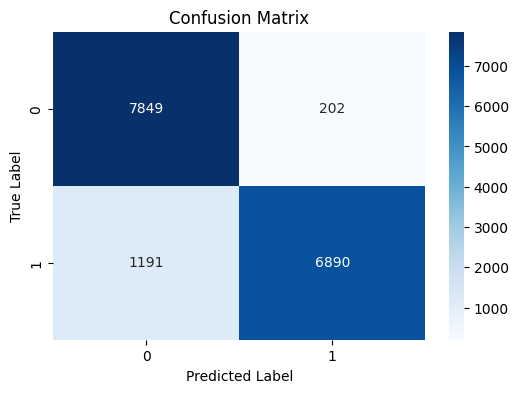

In [15]:
# Get the predictions and true labels for the test set
preds, true_labels = get_predictions_and_labels(model, binaryDL_val)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, preds)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()